In [26]:
##Import
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import PIL


The images and labels

In [27]:
#strings that contain the pathlinks:

#images
imagedir = '../../data/processed_data/specgram_db_pad_trunc.npy'
images = np.load(imagedir)
#labels
labeldir = '../../data/processed_data/metadata_category_to_number.csv'
#the actual labels
df = pd.read_csv(labeldir)
df.iloc[0,6]



1

In [28]:
images = torch.from_numpy(images)


torch.Size([128, 67])


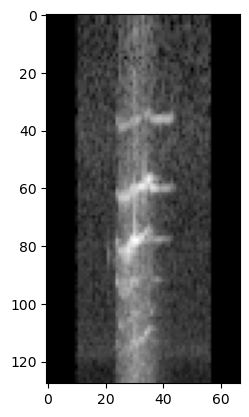

In [29]:
def showspec(image):
    plt.imshow(image, cmap='gray')
    plt.show
    
    
showspec(images[1])
print(images[1].shape)

Custom Dataset 

In [30]:

class CustomImageDataset(Dataset):
    """Meow dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.1
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv('../../data/processed_data/metadata_category_to_number.csv')
        self.root_dir = '../../data/processed_data/specgram_db_pad_trunc.npy'
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    """
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    """

    def __getitem__(self, idx):

       #load the images as numpy array and convert to tensor:
        X = np.load(self.root_dir)
        X = X.reshape(X.shape[0],1,  X.shape[1], X.shape[2])
        X = torch.from_numpy(X)
        Y = torch.tensor(self.landmarks_frame['numerical_situation'].values)
        x = X[idx]
        y = Y[idx]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y



In [31]:
from torchvision import transforms

transform = transforms.Compose([
    # transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean=0.5 and std=0.5
])
meow_dataset = CustomImageDataset(csv_file = labeldir ,
                                  root_dir= imagedir,
                                  transform=transform
                                  )


In [32]:
if __name__ == "__main__":
    dataset = meow_dataset

In [33]:
from torch.utils.data import DataLoader, random_split

# Assuming dataset is a PyTorch Dataset object
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Randomly split dataset into training and testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Feature batch shape: torch.Size([32, 1, 128, 67])
Labels batch shape: torch.Size([32])


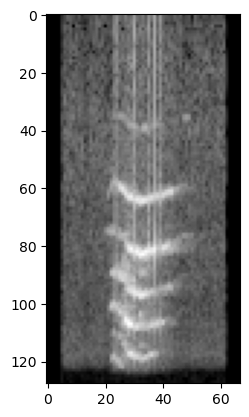

Label: 2


In [34]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [106]:
import torch.nn as nn
import torch.nn.functional as F

'''
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
'''
'''
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, (6,3))
        self.pool = nn.MaxPool2d((2,2), 2)
        self.conv2 = nn.Conv2d(32, 64, (6,3))
        self.pool = nn.MaxPool2d((2,2), 2)
        self.fc1 = nn.Linear(26880, 64)
        self.fc2 = nn.Linear(64, 3)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        #x = self.fc3(x)
        return x

'''


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3,3),stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=3, stride=1)
        self.fc1 = nn.Linear(16*30*15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,3)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, kernel_size=(2,2), stride=(2,2))
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2, 2)
        out = out.view(-1, 16*30*15) #flattening
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
net = Net()

In [107]:
from torchsummary import summary

summary(net, input_size=(1, 128, 67))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6, 126, 65]              60
            Conv2d-2           [-1, 16, 61, 30]             880
            Linear-3                  [-1, 120]         864,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                    [-1, 3]             255
Total params: 875,479
Trainable params: 875,479
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Params size (MB): 3.34
Estimated Total Size (MB): 3.97
----------------------------------------------------------------


In [108]:
def Get_Accuracy(model,data):
  softmax=nn.Softmax(dim=1)
  correct = 0
  total = 0
  with torch.no_grad():
    # Iterate through test dataset
    for i, (images, labels) in enumerate(data):

        images=images.to(device)
        labels=labels.to(device)

        # Forward pass only to get logits/output
        outputs = softmax(model(images))
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

  accuracy = 100 * correct / total
  return accuracy

In [113]:
import torch.optim as optim
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
'''
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99)
learning_rate = 0.01
weight_decay = .001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

In [114]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
model = net
model.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [115]:
num_epochs=15
trainingEpoch_loss = []
validationEpoch_loss = []
for epoch in range(num_epochs):
    loss_avg=0
    for i, (images, labels) in enumerate(train_loader):
        # move to gpu
        images=images.to(device)
        labels=labels.to(device)
        # make prediction
        y_pred = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(y_pred, labels)

        # Resets the gradients of all optimized torch
        optimizer.zero_grad()
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        loss_avg+=loss.item()*(labels.size(0)/len(train_dataset))



    acc=Get_Accuracy(model,train_loader)
    validacc = Get_Accuracy(model,test_loader).item()
    trainingEpoch_loss.append(acc)
    validationEpoch_loss.append(validacc)
    # acc_val=Get_Accuracy(model, validation_loader)
    # print(f"Epoch {epoch}. Loss: {loss_avg} train accuracy: {acc}.  val accuracy: {acc_val}")
    print(f"Epoch {epoch}. Loss: {loss_avg} train accuracy: {acc}.")
print('Done')

Epoch 0. Loss: 0.3181955326687206 train accuracy: 77.55681610107422.
Epoch 1. Loss: 0.3195456185124137 train accuracy: 92.61363983154297.
Epoch 2. Loss: 0.35531738535924395 train accuracy: 93.18181610107422.
Epoch 3. Loss: 0.4167539707639001 train accuracy: 88.92045593261719.
Epoch 4. Loss: 0.25705302980813116 train accuracy: 95.17045593261719.
Epoch 5. Loss: 0.11466134881431407 train accuracy: 98.29545593261719.
Epoch 6. Loss: 0.03484673328189687 train accuracy: 100.0.
Epoch 7. Loss: 0.07225532321767374 train accuracy: 99.43181610107422.
Epoch 8. Loss: 0.10254428586499258 train accuracy: 99.1477279663086.
Epoch 9. Loss: 0.14282769748983398 train accuracy: 97.15908813476562.
Epoch 10. Loss: 0.11202622543681753 train accuracy: 98.86363983154297.
Epoch 11. Loss: 0.08586583997715605 train accuracy: 99.71591186523438.
Epoch 12. Loss: 0.09005264605564828 train accuracy: 88.63636016845703.
Epoch 13. Loss: 0.17613701149821284 train accuracy: 97.44318389892578.
Epoch 14. Loss: 0.03302733007479

In [116]:
Get_Accuracy(model,test_loader).item()

63.6363639831543

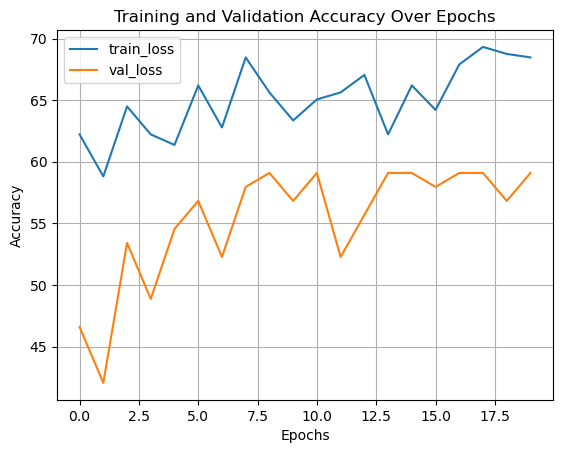

In [94]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
# Customize the plot
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [95]:
PATH = './dummy_net.pth'
torch.save(net.state_dict(), PATH)

Feature batch shape: torch.Size([32, 1, 128, 67])
Labels batch shape: torch.Size([32])
torch.Size([1, 128, 67])


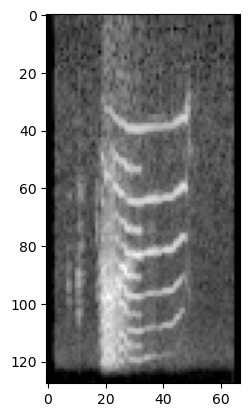

Label: 1


In [50]:
# Display image and label.
test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
print(test_features[0].shape)
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [61]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [62]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [63]:
outputs = net(images)

In [64]:
_, predicted = torch.max(outputs, 1)

In [65]:
print( labels)
print(outputs)
print(torch.max(outputs, 1))
#print('Predicted: ', ' '.join(f'{predicted[j]:5s}'
                              #for j in range(4)))

tensor([1, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2,
        0, 2, 0, 2, 0, 0, 1, 1])
tensor([[6.6236e-02, 9.0135e-06, 1.2195e-04],
        [1.2616e-03, 7.9196e-03, 1.1541e-04],
        [6.0516e-05, 3.2361e-05, 7.6073e-03],
        [3.8046e-05, 4.5744e-03, 6.5964e-03],
        [5.9235e-02, 3.1569e-04, 8.1402e-05],
        [1.3899e-03, 2.2366e-05, 3.3484e-02],
        [5.3891e-04, 5.3507e-03, 1.2351e-02],
        [2.4196e-02, 1.9520e-01, 1.6794e-05],
        [5.0095e-03, 6.4064e-03, 6.2809e-04],
        [6.4970e-03, 3.4466e-05, 2.9688e-04],
        [4.6196e-02, 8.2028e-04, 1.8099e-04],
        [1.1806e-03, 1.9963e-05, 4.2739e-03],
        [7.2170e-03, 1.3915e-02, 2.0768e-04],
        [4.4588e-04, 2.7997e-06, 2.1999e-01],
        [5.4226e-03, 1.0068e-02, 2.8769e-04],
        [1.0964e-03, 2.0126e-06, 4.8904e-01],
        [1.9874e-04, 3.0966e-03, 7.3527e-02],
        [2.4599e-03, 5.2581e-05, 5.8804e-03],
        [6.1325e-04, 1.5365e-04, 5.3293e-02],
        [1.72

In [56]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print( labels)
images, labels = next(dataiter)
print( labels)

tensor([1, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2,
        0, 2, 0, 2, 0, 0, 1, 1])
tensor([2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 0,
        0, 0, 0, 0, 2, 2, 1, 0])
